# Курс «Введение в нейронные сети»

## Урок 6. Сегментация

### Домашняя работа к уроку 6

In [35]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [108]:
def resize_normalize(row):
    image = row['image']
    label = row['label']
    image = tf.cast(image,tf.uint8)
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    image = image / 255.0
    return image, label

In [114]:
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  return image, label

In [52]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [41]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose( output_channels, 3, strides=2, padding='same')

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [43]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [44]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#### Задание 1

Попробуйте обучить нейронную сеть U-Net либо на другом датасете либо с другим бэкбоном (другой свёрточной частью). Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

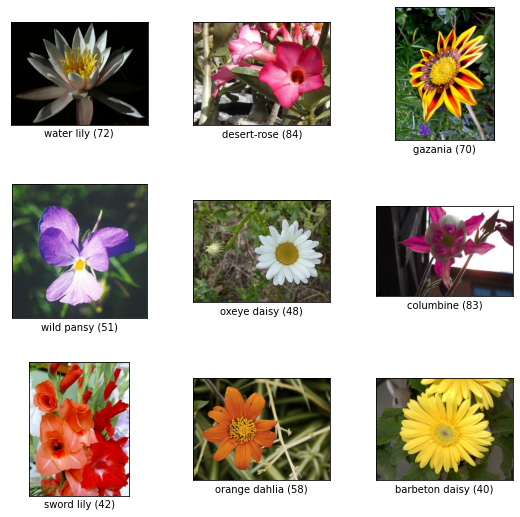

In [72]:
(raw_train, raw_val, raw_test), metadata = tfds.load('tf_flowers', 
                                                     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                                     with_info=True)
fig = tfds.show_examples(dataset, info)

In [109]:
num_train, num_val, num_test = (metadata.splits['train'].num_examples * weight/10 for weight in SPLIT_WEIGHTS)
print('Number of training samples {}'.format(num_train))

Number of training samples 2936.0


In [110]:
print(raw_train)
print(raw_val)
print(raw_test)

<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [111]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [112]:
train = raw_train.map(resize_normalize)
val = raw_val.map(resize_normalize)
test = raw_test.map(resize_normalize)

In [115]:
train = train.map(augment)

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [116]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

In [127]:
for image, mask in train.take(1):
      sample_image, sample_mask = image, mask
# display([sample_image, sample_mask])

In [128]:
OUTPUT_CHANNELS = 3

In [119]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [120]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [121]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [122]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [129]:
# show_predictions()

In [133]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/5


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [1048576,3] and labels shape [64]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-124-b8922a79a8ba>:9) ]] [Op:__inference_train_function_13966]

Function call stack:
train_function


In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()